In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.37'

In [3]:
from fastai import *
from fastai_audio import *

In [4]:
defaults.device = torch.device('cuda', 0)

In [23]:
from sklearn.model_selection import train_test_split

In [5]:
from utils import *
from models import AudioCNN

In [6]:
DATA = Path('data')
AUDIOSET = DATA/'audioset_mono'
TRAIN_CSV = AUDIOSET/'train_v2.csv'
VALID_CSV = AUDIOSET/'valid_v2.csv'
LABEL_CSV = AUDIOSET/'class_labels_indices.csv'

def convert_labels(df, label_df):
    df['positive_labels'] = df['positive_labels'].apply(
        lambda s: label_df.loc[s.split(','), 'display_name'].tolist())
    return df

label_df = pd.read_csv(LABEL_CSV, index_col='mid', usecols=['mid', 'display_name'])
train_df, valid_df = [convert_labels(pd.read_csv(f), label_df)
                      for f in [TRAIN_CSV, VALID_CSV]]
len(train_df), len(valid_df)

(18725, 17492)

In [7]:
n_fft = 512
n_hop = 256
n_mels = 128
sample_rate = 22050
top_db = 50.0
ref = 1.0

bs = 8

trn_batch_tfms = get_frequency_batch_transforms(
    n_fft=n_fft, n_hop=n_hop, n_mels=n_mels, 
    sample_rate=sample_rate, rand_hop_pct=0.15)

val_batch_tfms = get_frequency_batch_transforms(
    n_fft=n_fft, n_hop=n_hop, n_mels=n_mels, 
    sample_rate=sample_rate)

tfms = get_transforms(min_len=n_fft)

In [8]:
train_list = AudioItemList.from_df(train_df, 
                                   path=AUDIOSET, 
                                   folder='train', 
                                   suffix='.wav')
valid_list = AudioItemList.from_df(valid_df, 
                                   path=AUDIOSET,
                                   folder='valid', 
                                   suffix='.wav')

data = (ItemLists(path=AUDIOSET,
                  train=train_list,
                  valid=valid_list)
            .label_from_df()
            .transform(tfms)
            .databunch(bs=bs, 
                       equal_lengths=True, 
                       collate_fn=pad_collate1d))

data.train_dl.add_tfm(trn_batch_tfms[0])
data.valid_dl.add_tfm(val_batch_tfms[0])

len(data.train_ds), len(data.valid_ds)

(18725, 17492)

In [9]:
xs, ys = data.one_batch()
xs.shape, ys.shape

(torch.Size([8, 1, 128, 856]), torch.Size([8, 527]))

In [11]:
fbeta5 = partial(fbeta, thresh=0.5)
precision5 = partial(precision, thresh=0.5)
recall5 = partial(recall, thresh=0.5)

metrics = [precision, recall, fbeta, precision5, recall5, fbeta5]

In [12]:
model_name = 'audioset_audiocnn_512_256_v1'

model = AudioCNN(data.c)
learn = Learner(data, model, metrics=metrics)
# learn.fit_one_cycle(8)
# learn.save(model_name + '-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


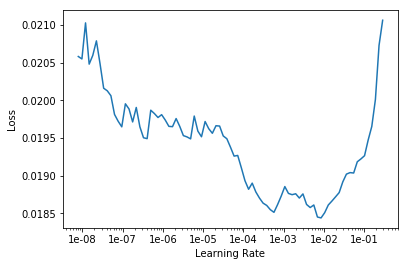

In [13]:
learn.load(model_name + '-stage-1')
learn.lr_find(start_lr=1e-9, end_lr=1)
learn.recorder.plot()

In [15]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(42, max_lr=1e-3)
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,precision,recall,fbeta,precision,recall,fbeta
1,0.018625,0.020160,0.413676,0.210384,0.224213,0.286636,0.113270,0.126313
2,0.018885,0.020150,0.413189,0.213630,0.227185,0.294392,0.116732,0.130144
3,0.018467,0.020227,0.413788,0.211734,0.225481,0.299151,0.118752,0.132352
4,0.018452,0.020199,0.408455,0.212085,0.224918,0.284803,0.114012,0.126794
5,0.018929,0.020160,0.416925,0.213205,0.226990,0.301006,0.119590,0.133192
6,0.018399,0.020075,0.409898,0.217878,0.230361,0.293328,0.118055,0.131189
7,0.018648,0.020727,0.397231,0.201204,0.213590,0.245956,0.097782,0.108617
8,0.018562,0.020942,0.379643,0.202486,0.212802,0.251926,0.104640,0.115223
9,0.017454,0.020502,0.405238,0.204809,0.218250,0.270518,0.108755,0.120648
10,0.018414,0.020148,0.411579,0.221444,0.233364,0.282021,0.114010,0.126467


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


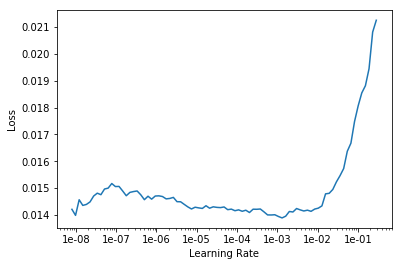

In [16]:
learn.load(model_name + '-stage-2')
learn.lr_find(start_lr=1e-9, end_lr=1)
learn.recorder.plot()

In [17]:
learn.load(model_name + '-stage-2')
learn.fit_one_cycle(8, max_lr=3e-3)
learn.save(model_name + '-stage-3')

epoch,train_loss,valid_loss,precision,recall,fbeta,precision,recall,fbeta
1,0.015908,0.021266,0.388450,0.251300,0.253364,0.315540,0.141965,0.154191
2,0.019257,0.023529,0.377187,0.225085,0.229313,0.253167,0.111077,0.120245
3,0.018928,0.022200,0.402471,0.201145,0.215082,0.269995,0.108682,0.120617
4,0.018158,0.022208,0.369850,0.191270,0.202100,0.184748,0.075974,0.084114
5,0.017632,0.022122,0.368299,0.215861,0.223195,0.269158,0.119685,0.130057
6,0.017118,0.020244,0.431867,0.244778,0.253185,0.343640,0.151645,0.165088
7,0.015710,0.019866,0.424514,0.250195,0.257809,0.320318,0.144608,0.156531
8,0.015361,0.019739,0.426222,0.260070,0.265994,0.343961,0.158692,0.171061


In [18]:
learn.load(model_name + '-stage-2')
torch.save(learn.model.state_dict(), 'audioset_50epochs.pt')

### Fine-tune on Freesound

In [35]:
metrics = [accuracy, mapk]

model = AudioCNN(527)
model.load_state_dict(torch.load('audioset_50epochs.pt'))

In [25]:
DATA = Path('data')
AUDIO = DATA/'freesound/audio_22050_trimmed'
CSV = DATA/'freesound/audio_44KHz/train_with_lens.csv'
TEST_CSV = DATA/'freesound/audio_44KHz/test_with_lens.csv'

df = pd.read_csv(CSV)
if df['fname'].iloc[0].endswith('.wav'):
    df['fname'] = df['fname'].str[:-4]
    df.drop(['manually_verified'], axis=1, inplace=True)

# validation split; stratified by label
idx = np.arange(len(df))
train_idx, valid_idx = train_test_split(idx, test_size=0.2, stratify=df['label'])
df['valid'] = False
df.loc[df.iloc[valid_idx].index, 'valid'] = True

test_df = pd.read_csv(TEST_CSV)
test_data = AudioItemList.from_df(test_df, path=AUDIO, folder='test', suffix='.wav')

data = (AudioItemList
            .from_df(df, path=AUDIO, folder='train', suffix='.wav')
            .split_from_df('valid')
            .label_from_df()
            .add_test(test_data)
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=False, length_col=2))

data.train_dl.add_tfm(trn_batch_tfms[0])
data.valid_dl.add_tfm(val_batch_tfms[0])
data.test_dl.add_tfm(val_batch_tfms[0])

len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(7578, 1895, 9400)

In [26]:
head = nn.Sequential(nn.Conv2d(1024, data.c, kernel_size=3, stride=1, padding=1),
                     PoolFlatten())
cut = -2
learn = create_audio_cnn(data, model, cut, head=head, metrics=metrics)

In [27]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 16, 128, 2836]   144        False     
______________________________________________________________________
BatchNorm2d          [8, 16, 128, 2836]   32         True      
______________________________________________________________________
ReLU                 [8, 16, 128, 2836]   0          False     
______________________________________________________________________
Conv2d               [8, 16, 128, 2836]   2304       False     
______________________________________________________________________
BatchNorm2d          [8, 16, 128, 2836]   32         True      
______________________________________________________________________
ReLU                 [8, 16, 128, 2836]   0          False     
______________________________________________________________________
MaxPool2d            [8, 16, 64, 1418]    0          False     
______________________________________________________________

In [28]:
model_name = 'finetune_audioset50'

learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy,mapk
1,3.175794,2.915984,0.343008,0.457608
2,2.077403,1.781731,0.476517,0.602199
3,1.736492,1.731079,0.496570,0.616359
4,1.512335,1.599740,0.558311,0.658047
5,1.605974,1.622882,0.559894,0.657872
6,1.487239,1.601591,0.572032,0.667810
7,1.509819,1.613047,0.571504,0.669833
8,1.447458,1.591314,0.577309,0.673527


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


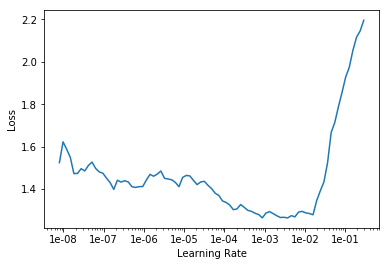

In [29]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-9, end_lr=1)
learn.recorder.plot()

In [30]:
learn.load(model_name + '-stage-1')
learn.fit_one_cycle(8, max_lr=slice(1e-4, 1e-3))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,accuracy,mapk
1,1.358112,1.591404,0.580475,0.675813
2,1.300740,1.707461,0.575726,0.672736
3,1.148300,1.459112,0.629551,0.723307
4,1.040541,1.296647,0.661741,0.742041
5,0.887677,1.337136,0.670185,0.753650
6,0.722880,1.263784,0.689710,0.766755
7,0.707226,1.300281,0.684433,0.762885
8,0.630020,1.294748,0.691821,0.768338


In [31]:
DATA = Path('data')
AUDIO = DATA/'freesound/audio_22050_trimmed_tfms'

CSV = DATA/'freesound/audio_44KHz/train_with_lens.csv'
TEST_CSV = DATA/'freesound/audio_44KHz/test_with_lens.csv'

In [32]:
df = pd.read_csv(CSV)
if df['fname'].iloc[0].endswith('.wav'):
    df['fname'] = df['fname'].str[:-4]
    df.drop(['manually_verified'], axis=1, inplace=True)

# validation split; stratified by label
idx = np.arange(len(df))
train_idx, valid_idx = train_test_split(idx, test_size=0.2, stratify=df['label'])
df['valid'] = False
df.loc[df.iloc[valid_idx].index, 'valid'] = True

def tfm_df(df, n_tfms=5):
    dfs = []
    for i in range(n_tfms + 1):
        suffix = '_{:02d}'.format(i)
        new_df = df.copy()
        new_df['fname'] = new_df['fname'] + suffix
        dfs.append(new_df)
    tfm_df = pd.concat(dfs)
    return tfm_df
        
df_tfm = tfm_df(df)
# two files were corrupt when generating transformed files, just remove them from df
df_tfm = df_tfm[~df_tfm['fname'].isin(['255db1a8_05', 'f406520b_01'])]
drop_idx = (df_tfm['valid'] == True) & (~df_tfm['fname'].str.endswith('_00'))
df_final = df_tfm[~drop_idx]
len(df_tfm), df_final['valid'].sum(), (~df_final['valid']).sum()

(56836, 1895, 45467)

In [33]:
data = (AudioItemList
            .from_df(df_final, path=AUDIO, folder='train', suffix='.wav')
            .split_from_df('valid')
            .label_from_df()
            .add_test(test_data)
            .transform(tfms)
            .databunch(bs=bs, equal_lengths=False, length_col=2))
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(45467, 1895, 9400)

In [34]:
data.train_dl.add_tfm(trn_batch_tfms[0])
data.valid_dl.add_tfm(val_batch_tfms[0])
data.test_dl.add_tfm(val_batch_tfms[0])

In [36]:
learn = create_audio_cnn(data, model, cut, head=head, metrics=metrics)

In [37]:
model_name = 'finetune_audioset50_tfms'

learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

epoch,train_loss,valid_loss,accuracy,mapk
1,1.954180,1.900099,0.462797,0.575374
2,1.592466,1.663451,0.568865,0.662621
3,1.272144,1.650499,0.580475,0.676166
4,1.244253,1.602033,0.619525,0.700264
5,1.286010,1.579582,0.617414,0.704925
6,1.102845,1.528362,0.624274,0.713017
7,1.149577,1.557012,0.624274,0.710642
8,1.065065,1.548334,0.624274,0.712225
